# Customer Segmentation for a retail purchasing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import raw data

The data can be downloaded from the "UC Irvine Machine Learning Repository [here](https://archive.ics.uci.edu/dataset/502/online+retail+ii).

In [2]:
orders_raw_df = pd.read_excel("data/orders.xlsx", sheet_name=0)
orders_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None


In [3]:
orders_raw_df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Information about the dataset

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

`InvoiceNo:` Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

`StockCode:` Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 

`Description:` Product (item) name. Nominal. 

`Quantity:` The quantities of each product (item) per transaction. Numeric.	

`InvoiceDate:` Invice date and time. Numeric. The day and time when a transaction was generated. 

`UnitPrice:` Unit price. Numeric. Product price per unit in sterling (Â£). 

`CustomerID:` Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 

`Country:` Country name. Nominal. The name of the country where a customer resides.


We see that the `Customer ID` column has `417,534` non-null entries whereas the dataset has `525,461` rows. Since our obejective is customer segmentation, we will remove all the rows which do not have a `Customer ID`.

In [4]:
cleaned_df = orders_raw_df.copy()
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype(str)
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype(str)
cleaned_df["Description"] = cleaned_df["Description"].astype(str)
cleaned_df["Customer ID"] = cleaned_df["Customer ID"].astype(str)
cleaned_df["Country"] = cleaned_df["Country"].astype(str)

In [5]:
cleaned_df.drop(cleaned_df.loc[cleaned_df["Customer ID"]=="nan"].index, inplace=True)

In [6]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417534 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  object        
 7   Country      417534 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 28.7+ MB


#### Check the non-numeric invoice numbers. The dataset description says the invoices are 6 digit numbers, except for cancelled ones which start with `c`

In [7]:
unique_invoices = cleaned_df["Invoice"].unique().tolist()
unique_invoices = [str(x) for x in unique_invoices]
non_numeric_invoice_numbers = [x for x in unique_invoices if not x.isnumeric()]
start_letter_non_numeric = [x[0] for x in non_numeric_invoice_numbers]

In [8]:
set(start_letter_non_numeric)

{'C'}

All the non-numeric `Invoice` start with `C` which are cancelled orders.

In [9]:
non_numeric_invoice_df = cleaned_df.loc[cleaned_df["Invoice"].isin(non_numeric_invoice_numbers)]
non_numeric_invoice_df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

array(['C'], dtype=object)

Looks like all non-numeric invoices start with C and are mostly cancellations. Need to confirm this if the quantity is negative for all of these.

In [10]:
non_numeric_invoice_df.loc[non_numeric_invoice_df["Quantity"]>0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


Let us create a seperate dataframe for the cancelled invoices.

In [11]:
cancelled_orderd_df = non_numeric_invoice_df[:]
del non_numeric_invoice_df

In [12]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price
count,417534.000000,417534,417534.000000
mean,12.758815,2010-07-01 01:12:19.787609856,3.887547
min,-9360.000000,2009-12-01 07:45:00,0.000000
25%,2.000000,2010-03-26 11:26:00,1.250000
50%,4.000000,2010-07-08 19:12:00,1.950000
75%,12.000000,2010-10-14 14:08:00,3.750000
max,19152.000000,2010-12-09 20:01:00,25111.090000
std,101.220424,NaN,71.131797


Let us drop the cancelled orders and do the customer segmentation. The proportion of customer's cancelling the order's can be analzed seperatley.

In [13]:
cleaned_df.drop(cancelled_orderd_df.index, inplace=True)

In [14]:
percentage_retained_data = len(cleaned_df)*100/len(orders_raw_df)
print(f"The percentage of retained record from the original dataset after cleaning is: {percentage_retained_data:.2f} %")

The percentage of retained record from the original dataset after cleaning is: 77.59 %


In [15]:
cleaned_df["Total Price"] = cleaned_df["Quantity"] * cleaned_df["Price"]
cleaned_df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


### Aggregate by Customer ID

In [16]:
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index=False) \
                            .agg(
                                TotalValue=("Total Price", "sum"),
                                Frequency=("Invoice", "nunique"),
                                LastTransactionDate=("InvoiceDate", "max")
                            )

In [18]:
aggregated_df.head(5)

,Customer ID,TotalValue,Frequency,LastTransactionDate
0,12346.0,372.86,11,2010-06-28 13:53:00
1,12347.0,1323.32,2,2010-12-07 14:57:00
2,12348.0,222.16,1,2010-09-27 14:59:00
3,12349.0,2671.14,3,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00


Let us create a column which gives information about how recently was the customer's last order. Since we are analyzing old date and also for this feature to be static, we can consider the maximum of all the transaction date to pivot and find the other customer's last order.

In [19]:
aggregated_df["Recency"] = (aggregated_df["LastTransactionDate"].max()-aggregated_df["LastTransactionDate"]).dt.days

In [20]:
aggregated_df.head(5)

,Customer ID,TotalValue,Frequency,LastTransactionDate,Recency
0,12346.0,372.86,11,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,222.16,1,2010-09-27 14:59:00,73
3,12349.0,2671.14,3,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10


In [21]:
aggregated_df.describe().T

,count,mean,min,25%,50%,75%,max,std
TotalValue,4314.0,2047.288659,0.0,307.95,705.55,1722.8025,349164.35,8912.523243
Frequency,4314.0,4.454103,1.0,1.0,2.0,5.0,205.0,8.168658
LastTransactionDate,4314,2010-09-10 06:48:35.855354624,2009-12-01 09:55:00,2010-07-27 09:41:45,2010-10-18 16:11:30,2010-11-22 10:55:45,2010-12-09 20:01:00,NaN
Recency,4314.0,90.269124,0.0,17.0,52.0,135.0,373.0,96.943482


### Distribution Analysis

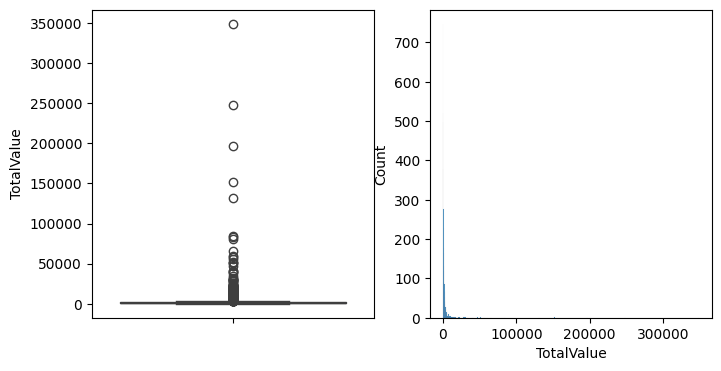

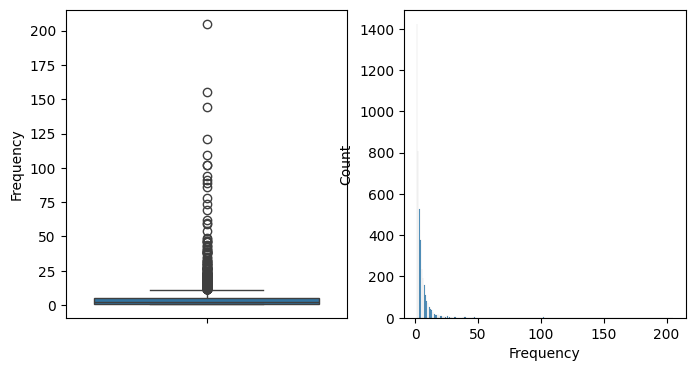

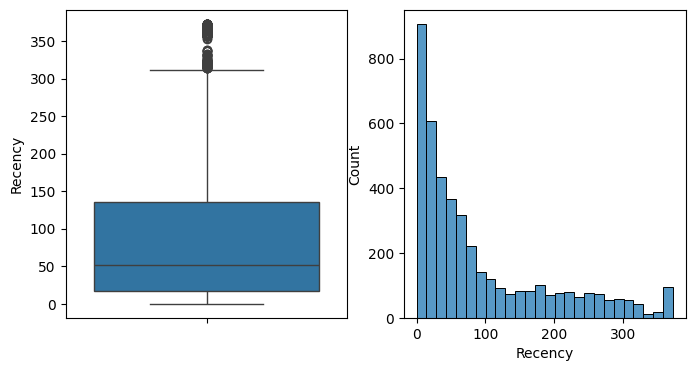

In [22]:
for col in ["TotalValue", "Frequency", "Recency"]:
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    sns.boxplot(aggregated_df, y=col)
    plt.subplot(1,2,2)
    sns.histplot(aggregated_df, x=col)
    plt.show()

`TotalValue` and `Frequency` have significant outliers which will make our customer segmentation algorithm to be biased to these data-points. So we need to remove them.

All the data-points that are beyond 1.5 times the inter-quartile range are considered as outliers.

In [23]:
TV_Q1 = aggregated_df["TotalValue"].quantile(0.25)
TV_Q3 = aggregated_df["TotalValue"].quantile(0.75)
TV_IQR = TV_Q3 - TV_Q1
TV_UP_THLD = TV_Q3 + 1.5 * TV_IQR
TV_LOW_THLD = TV_Q1 - 1.5 * TV_IQR
TV_outliers_df = aggregated_df.loc[(aggregated_df["TotalValue"]>TV_UP_THLD) | (aggregated_df["TotalValue"]<TV_LOW_THLD)]

In [24]:
F_Q1 = aggregated_df["Frequency"].quantile(0.25)
F_Q3 = aggregated_df["Frequency"].quantile(0.75)
F_IQR = F_Q3 - F_Q1
F_UP_THLD = F_Q3 + 1.5 * F_IQR
F_LOW_THLD = F_Q1 - 1.5 * F_IQR
F_outliers_df = aggregated_df.loc[(aggregated_df["Frequency"]>F_UP_THLD) | (aggregated_df["Frequency"]<F_LOW_THLD)]

In [25]:
non_outliers_df = aggregated_df.loc[(~aggregated_df.index.isin(TV_outliers_df.index)) & (~aggregated_df.index.isin(F_outliers_df.index))]

Let us check the distributions again after removing the outliers

In [27]:
non_outliers_df.describe().T

,count,mean,min,25%,50%,75%,max,std
TotalValue,3830.0,889.399422,0.0,280.9225,588.625,1273.3025,3817.18,824.842965
Frequency,3830.0,2.863446,1.0,1.0,2.0,4.0,11.0,2.241468
LastTransactionDate,3830,2010-09-02 12:56:34.010443776,2009-12-01 09:55:00,2010-07-07 10:15:00,2010-10-12 12:31:00,2010-11-17 13:07:45,2010-12-09 20:01:00,NaN
Recency,3830.0,98.013316,0.0,22.0,58.0,155.0,373.0,98.824058


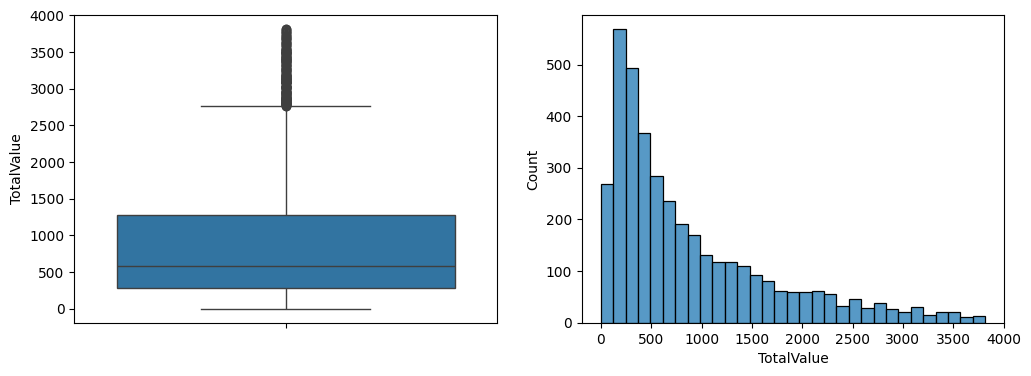

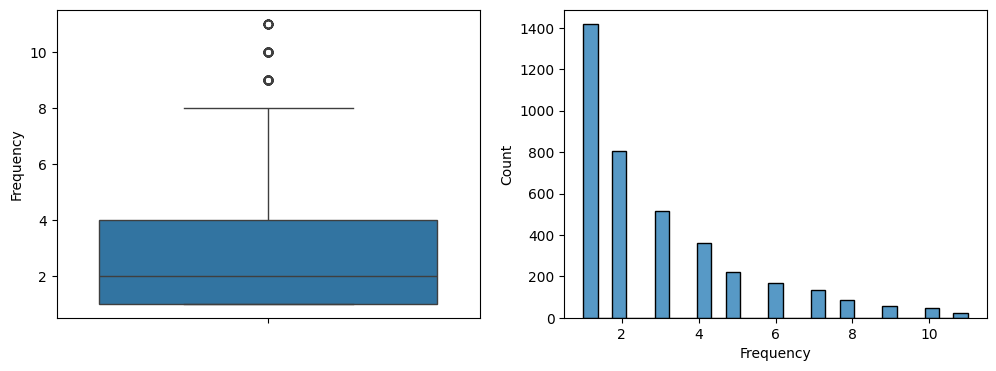

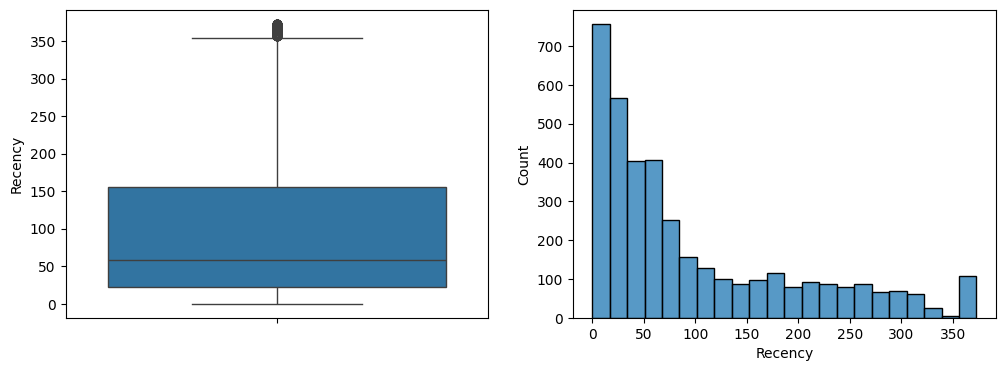

In [28]:
for col in ["TotalValue", "Frequency", "Recency"]:
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    sns.boxplot(non_outliers_df, y=col)
    plt.subplot(1,2,2)
    sns.histplot(non_outliers_df, x=col)
    plt.show()

The ditributions are right skewed. Since we have removed the outlier's we could proceed with customer segmentation on the remaining datpoints.

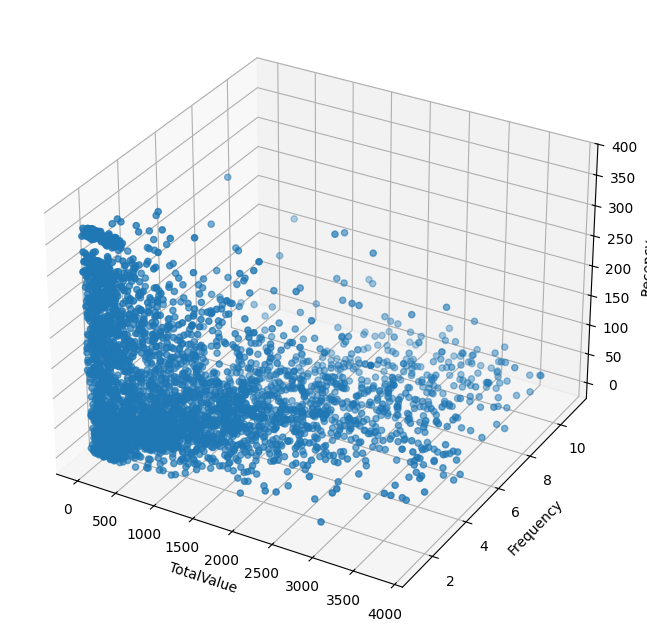

In [29]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["TotalValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])
ax.set_xlabel("TotalValue")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

plt.show()

Scaling of all the features is very important while doing customer segmentation when the features have big differnce in magnitude. 

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_outliers_df[["TotalValue", "Frequency", "Recency"]])

In [36]:
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=["TotalValue", "Frequency", "Recency"])

Text(0.5, 0, 'Recency')

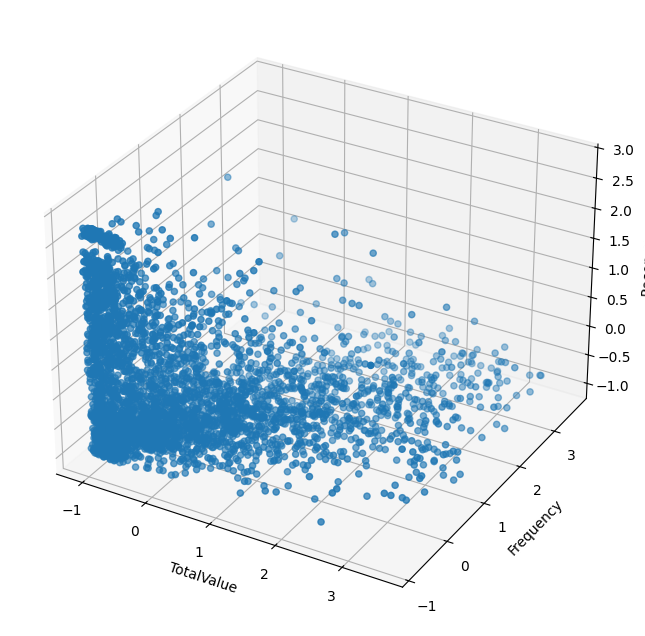

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["TotalValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])
ax.set_xlabel("TotalValue")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

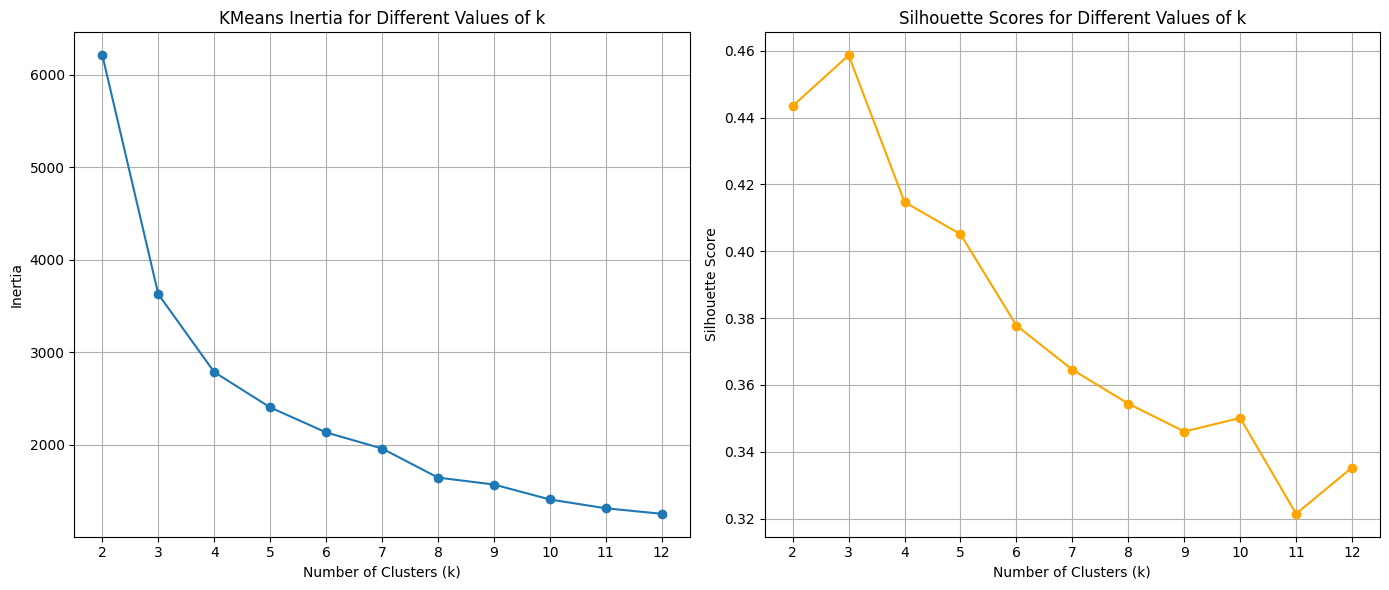

In [39]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([3, 2, 1, ..., 0, 2, 2], shape=(3830,), dtype=int32)

In [43]:
non_outliers_df["Cluster"] = cluster_labels[:]

/tmp/ipykernel_7932/2174816431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels[:]


In [44]:
non_outliers_df.head()

,Customer ID,TotalValue,Frequency,LastTransactionDate,Recency,Cluster
0,12346.0,372.86,11,2010-06-28 13:53:00,164,3
1,12347.0,1323.32,2,2010-12-07 14:57:00,2,2
2,12348.0,222.16,1,2010-09-27 14:59:00,73,1
3,12349.0,2671.14,3,2010-10-28 08:23:00,42,2
4,12351.0,300.93,1,2010-11-29 15:23:00,10,1


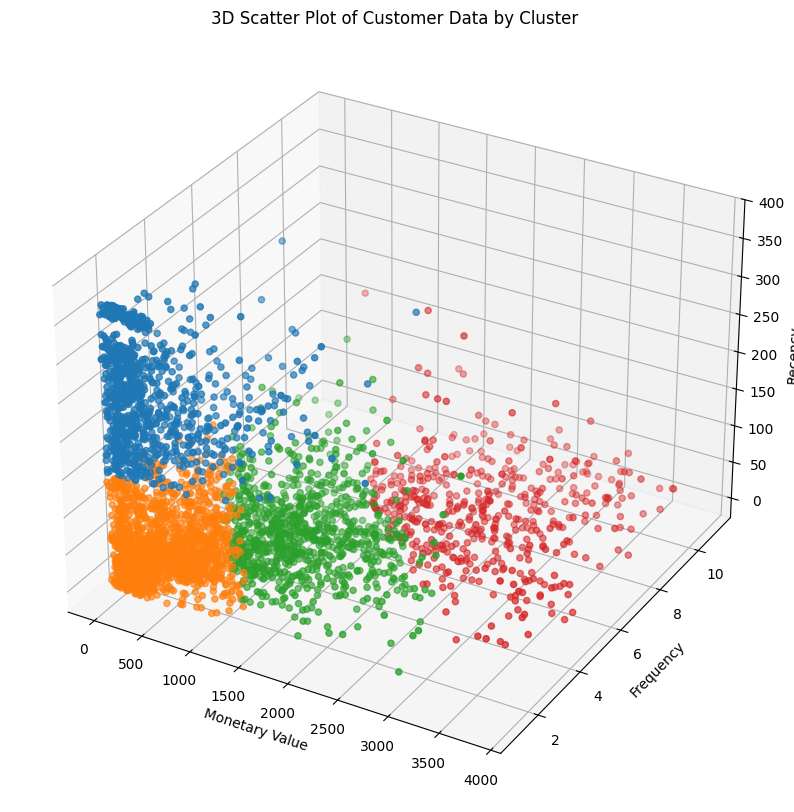

In [45]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['TotalValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

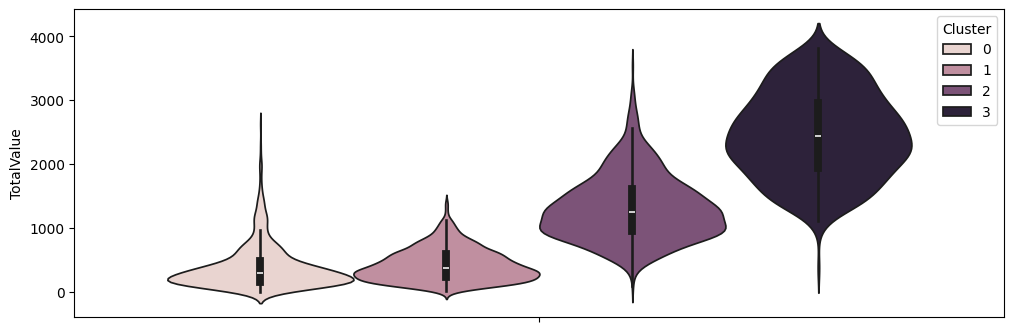

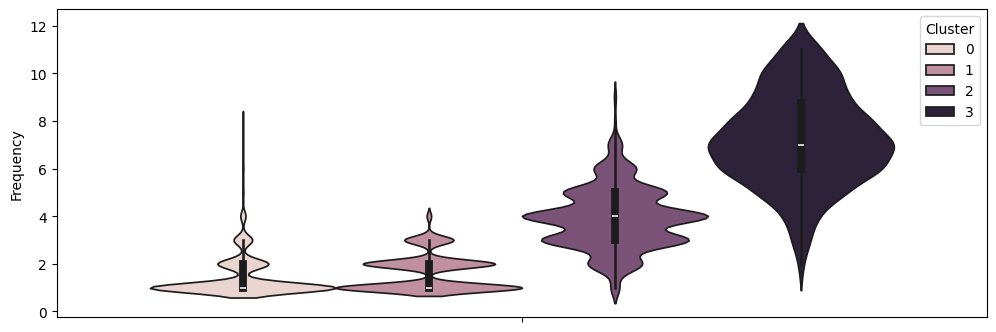

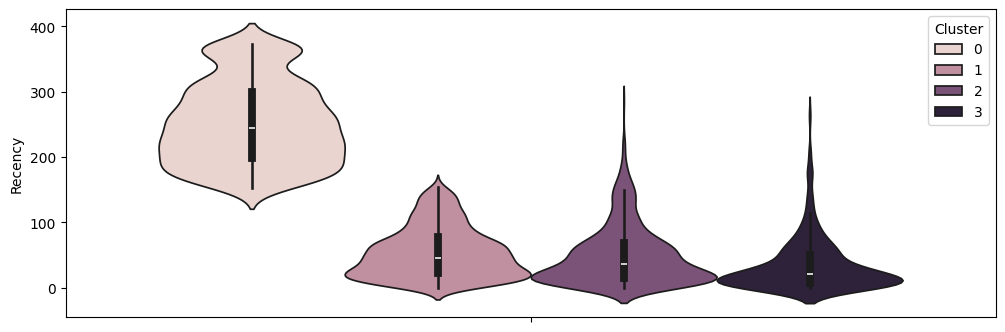

In [48]:
for col in ["TotalValue", "Frequency", "Recency"]:
    plt.figure(figsize=(12, 4))
    sns.violinplot(non_outliers_df, y=col, hue="Cluster")
    plt.show()

### Analyze the clusters

#### Cluster 0: Re-engage

- **Rationale:** These are low value, less to medium frequent buyers, and have not order recently.
- **Action Plan:** They need to be re-engaged with targeted marketing and offerered special discounts

#### Cluster 1: Nurture

- **Rationale:** These are low value, less to medium frequent buyers, but are recently very active.
- **Action Plan:** Nurture. Provide better engagement and offers to keep them buying.

#### Cluster 2: Retain

- **Rationale** These are medium value, medium frequent, and recent buyers. Very valuable and actible users.
- **Action Plan:** Implement loyalty programs and rewards, personlized offers.

#### Cluster 3: Reward

- **Rationale:** High value, very frequent, and very active.
- **ACtion Plan:** Implement robust loyalty program, exclusive offers.

### Analyze the customers who cancel the orders

In [49]:
cancelled_orderd_df["Total Price"] = cancelled_orderd_df["Quantity"] * cancelled_orderd_df["Price"]
cancelled_agg_df = cancelled_orderd_df.groupby(by="Customer ID", as_index=False).\
                                               agg(CancelledValue=("Total Price", "sum"),
                                                   CancellationFrequency=("Invoice", "nunique"),
                                                   LastCancelledDate=("InvoiceDate", "max"))

In [50]:
cancelled_agg_df.head(5)

,Customer ID,CancelledValue,CancellationFrequency,LastCancelledDate
0,12346.0,-437.54,4,2010-10-04 16:33:00
1,12349.0,-24.15,1,2009-12-04 12:49:00
2,12359.0,-94.00,2,2010-04-12 08:40:00
3,12360.0,-40.00,1,2010-05-25 10:01:00
4,12380.0,-1784.05,3,2010-11-23 12:06:00


In [51]:
aggregated_df.head(5)

,Customer ID,TotalValue,Frequency,LastTransactionDate,Recency
0,12346.0,372.86,11,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,222.16,1,2010-09-27 14:59:00,73
3,12349.0,2671.14,3,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10


In [52]:
cancelled_joined_df = cancelled_agg_df.merge(aggregated_df, how="left", left_on="Customer ID", right_on="Customer ID")

In [53]:
cancelled_joined_df.head(5)

,Customer ID,CancelledValue,CancellationFrequency,LastCancelledDate,TotalValue,Frequency,LastTransactionDate,Recency
0,12346.0,-437.54,4,2010-10-04 16:33:00,372.86,11.0,2010-06-28 13:53:00,164.0
1,12349.0,-24.15,1,2009-12-04 12:49:00,2671.14,3.0,2010-10-28 08:23:00,42.0
2,12359.0,-94.00,2,2010-04-12 08:40:00,2563.36,6.0,2010-10-10 11:16:00,60.0
3,12360.0,-40.00,1,2010-05-25 10:01:00,1590.83,5.0,2010-11-25 11:04:00,14.0
4,12380.0,-1784.05,3,2010-11-23 12:06:00,6951.49,7.0,2010-08-31 14:54:00,100.0


In [64]:
cancelled_joined_df["CancellationRate"]  = cancelled_joined_df["CancellationFrequency"] * 100 / (cancelled_joined_df["Frequency"] + cancelled_joined_df["CancellationFrequency"])

In [65]:
cancelled_joined_df.head(5)

,Customer ID,CancelledValue,CancellationFrequency,LastCancelledDate,TotalValue,Frequency,LastTransactionDate,Recency,CancellationRate
0,12346.0,-437.54,4,2010-10-04 16:33:00,372.86,11.0,2010-06-28 13:53:00,164.0,26.666667
1,12349.0,-24.15,1,2009-12-04 12:49:00,2671.14,3.0,2010-10-28 08:23:00,42.0,25.000000
2,12359.0,-94.00,2,2010-04-12 08:40:00,2563.36,6.0,2010-10-10 11:16:00,60.0,25.000000
3,12360.0,-40.00,1,2010-05-25 10:01:00,1590.83,5.0,2010-11-25 11:04:00,14.0,16.666667
4,12380.0,-1784.05,3,2010-11-23 12:06:00,6951.49,7.0,2010-08-31 14:54:00,100.0,30.000000


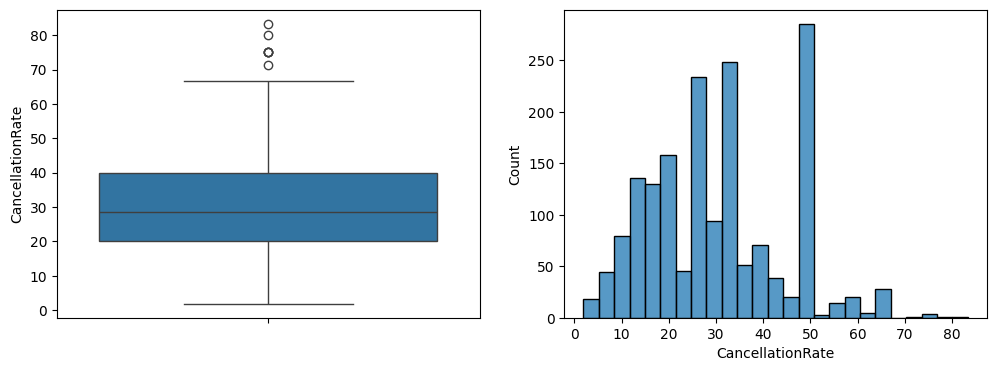

In [66]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.boxplot(cancelled_joined_df, y="CancellationRate")
plt.subplot(1,2,2)
sns.histplot(cancelled_joined_df, x="CancellationRate")
plt.show()

The customers whose cancellation percentage is more than 50% could be further looked into and they can be segmented into a risk class.

In [67]:
len(cancelled_joined_df.loc[cancelled_joined_df["CancellationRate"]>=50])*100/len(aggregated_df)

8.344923504867872

About 8% of the cutomers return more than 50% of their orders 